In [42]:
import sys
sys.path.append('../')

In [43]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import X_and_P_ops, RY_ansatz, VarFourier

In this notebook we show how to use our framework to obtain the ground state of the harmonic oscilator with Variational Fourier Analysis. Defining the number of qubits and the device for the simulation.

In [56]:
num_qubits = 4
device = qml.device( "default.qubit", 
                    wires=num_qubits)

Creating the Hamiltonian of the harmonic oscilator.

$$H=\frac{1}{2}( P^2 + X^2 )$$

In [57]:
X, P = X_and_P_ops( range(num_qubits), x_min=-5, x_max=5 )

Hamil = [  
        qml.s_prod(0.5,X.pow(2)),
        qml.s_prod(0.5,P.pow(2))
        ]

We can obtain its ground state by matricial calculations.

In [62]:
X_matrix = X.matrix()
P_matrix = P.matrix()
Hamil_matrix = 0.5*np.linalg.matrix_power( X_matrix, 2 ) + 0.5*np.linalg.matrix_power( P_matrix, 2 )
vals, vecs = np.linalg.eigh( Hamil_matrix )
val = vals[0]
vec = vecs[:,0]
val 

0.5000000011276833

Defining the initial state of the circuits and the variational circuit.

In [63]:
def init_state():
    pass 

In [64]:
num_layers = 4
var_state_class = RY_ansatz(num_qubits,num_layers)
var_state = var_state_class.construct_circuit

num_params = var_state_class.num_params
num_params

16

(<Figure size 1900x500 with 1 Axes>, <Axes: >)

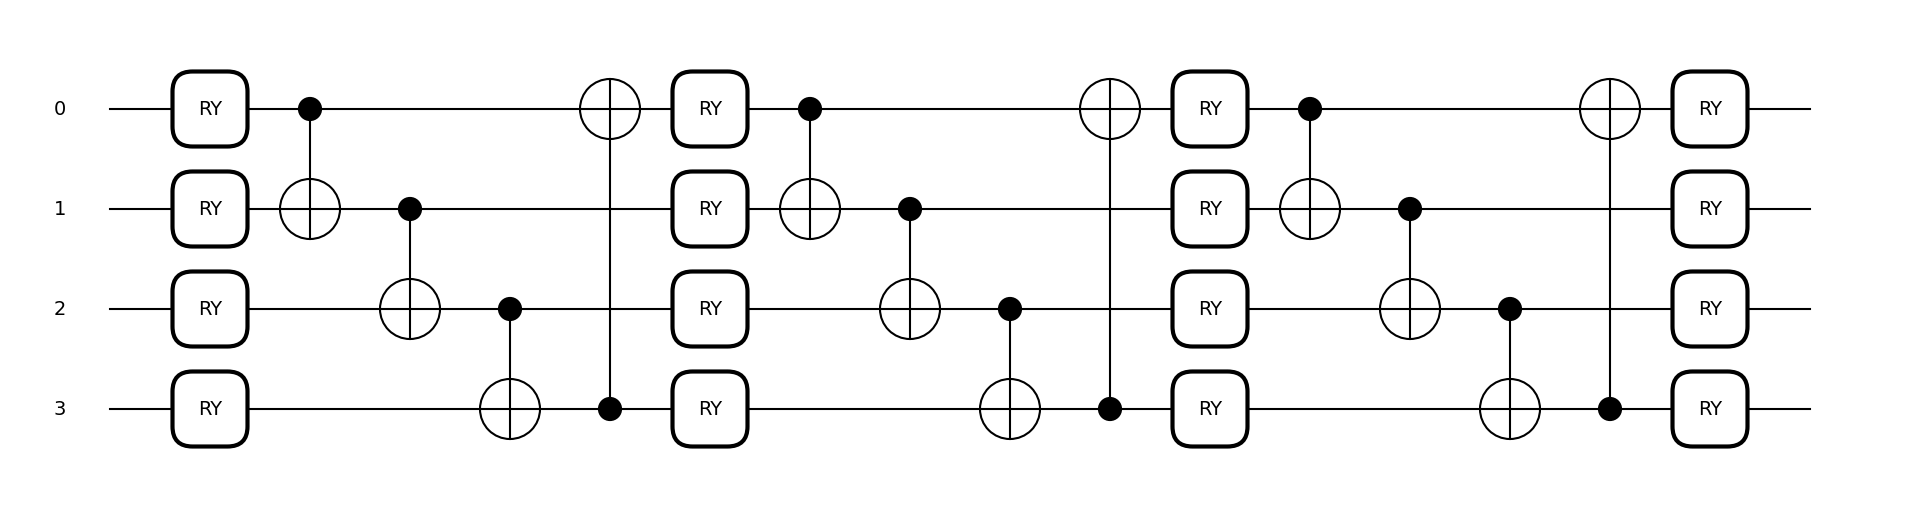

In [65]:
qml.draw_mpl( var_state )( num_params*[0] )

The class ```VarFourier``` create the solver to minimize the energy of the Hamiltonian $H$ over the variational circuit.

In [68]:
varqft = VarFourier( Hamil,
                    device,
                    var_state  = var_state,
                    init_state = init_state
                    )

The optimization is executed by the command ```VarFourier.run```. We have to include the initial condition, the other arguments are optional.

In [69]:
params_init = np.random.randn( num_params )*0.01

params_ground, energies_ground = varqft.run( params_init, max_iterations=500, learning_rate=0.1 )

Step:    146, Energy:     0.502966


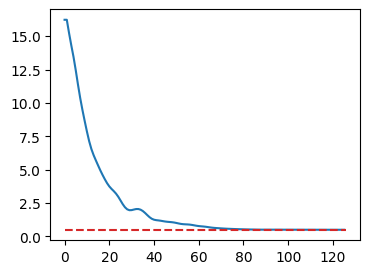

In [52]:
plt.figure( figsize=(4,3) ) 
plt.plot( energies_ground )
plt.hlines( val, 0, len(energies_ground), colors='tab:red', linestyles='--' ) 

Comparing the probability distribution of the estimated ground state $|\tilde{g}\rangle$ and the ideal one $|g\rangle$ we can see that they are very similar. The Fidelity $F=|\langle\tilde{g}|g\rangle|^2$ between them is the following:

In [75]:
ground_state = varqft.state( params_ground[-1] )
abs( np.vdot( ground_state, vec) )**2

0.9977655251789711

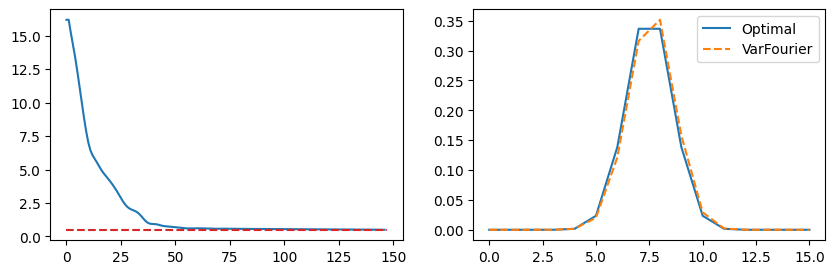

In [76]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( energies_ground )
ax[0].hlines( val, 0, len(energies_ground), colors='tab:red', linestyles='--' )
ax[1].plot( np.abs(vec)**2) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 